In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [33]:
class su2:
    def __init__(self):
        self.vec = (np.random.rand(4)*2 - 1 )
        self.vec /= np.sqrt(su2.det(self.vec))
        
    def heat_bath(self,stpl, beta):
        k = np.sqrt(su2.det(stpl))
        a = np.ones(4)
        while np.random.rand() < (1 - np.sqrt(1-a[0]**2)):
            x = np.random.rand()*(1-np.exp(-2*beta*k)) + np.exp(-2*beta*k)
            a[0] = 1 + (np.log(x)/(beta*k))
        a[1:] = (np.random.rand(3)*2 - 1)
        a[1:] *= np.sqrt((1-a[0]**2)/(a[1]**2 + a[2]**2 +a[3]**2))
        self.vec = su2.multi(a, su2.inv(stpl / k)) 
        
    def over_relaxation(self,stpl):
        k = np.sqrt(su2.det(stpl))
        self.vec = su2.inv(su2.staple(stpl/k,self.vec, stpl/k)) 
    def inv(u):
        return  np.array([u[0],-u[1],-u[2],-u[3]])
    
    def det(u):
        return (u[0]**2) + (u[1]**2) + (u[2]**2) + (u[3]**2)
    
    def trace(u):
        return 2 * u[0]
    def multi(u,v):
        return np.array([u[0]*v[0] - u[1]*v[1] - u[2]*v[2] - u[3]*v[3],
                u[0]*v[1] + u[1]*v[0] - u[3]*v[2] + u[2]*v[3],
                u[2]*v[0] + u[0]*v[2] - u[1]*v[3] + u[3]*v[1],
                u[3]*v[0] - u[2]*v[1] + u[0]*v[3] + u[1]*v[2]])
    def plaquette(self,u,v,w):
        return su2.multi(su2.multi(su2.multi(self.vec, u), v), w)[0]
    def staple(u,v,w):
        return su2.multi(su2.multi(u, v), w)

In [34]:
class Lattice:
    def __init__(self,Nt,Ns,Nhb,Nor,beta):
        self.beta = beta
        self.Nt = Nt; self.Ns = Ns;
        self.Nor = Nor; self.Nhb = Nhb;
        self.nodes = np.array([])
        for t in range(Nt):
            for x in range(Ns):
                for y in range(Ns):
                    for z in range(Ns):
                        for mu in range(4):
                            self.nodes = np.append(self.nodes,su2())
        self.nodes = self.nodes.reshape(Nt,Ns,Ns,Ns,4)
        
    def move(self,X,e, mu): 
        N = np.array([self.Nt,self.Ns,self.Ns,self.Ns])
        X = (X+e)*(((X+e)<N) * ((X+e)>=0)) + (N+e)*((X+e)<0) + ((X+e) - N)*((X+e)>=N);
        return self.nodes[X[0],X[1],X[2],X[3],mu].vec
    
    def polyakov_loop(self):
        lp = 0.
        for x in range(self.Ns):
            for y in range(self.Ns):
                for z in range(self.Ns):
                    lp_tmp = self.nodes[t,x,y,z,0]
                    for t in range(1, self.Nt):
                        lp_tmp = su2.multi(lp_tmp, self.nodes(t,x,y,z,0))
                    lp += su2.trace(lp_tmp)
        return lp / (2 * (self.Ns ** 3))
    def avr_plaquette(self):
        plq = 0.
        a = np.array([0,1,2,3])
        for t in range(self.Nt):
            for x in range(self.Ns):
                for y in range(self.Ns):
                    for z in range(self.Ns):
                        for mu in range(4):
                            for nu in a[a>mu]:
                                X = np.array([t,x,y,z])
                                e_mu = 1*(a==mu); e_nu = 1*(a==nu); zero = np.array([0,0,0,0]);
                                plq += self.nodes[t,x,y,z,mu].plaquette(self.move(X,e_mu,nu),
                                                    su2.inv(self.move(X,e_nu,mu)),
                                                                        su2.inv(self.move(X,zero,nu)))
        return plq / (self.Nt * (self.Ns ** 3) * 6)
        
    def staple(self,X,mu):
        stpl = np.array([0.,0.,0.,0.])
        a = np.array([0,1,2,3])
        for nu in a[a!=mu]:
            e_mu = 1*(a==mu); e_nu = 1*(a==nu); zero = np.array([0,0,0,0]);
            stpl += su2.staple(self.move(X,e_mu,nu),
                                su2.inv(self.move(X,e_nu,mu)),su2.inv(self.move(X,zero,nu)))
            stpl += su2.staple(su2.inv(self.move(X,e_mu-e_nu,nu)),
                                su2.inv(self.move(X,-e_nu,mu)),self.move(X,-e_nu,nu))
        return stpl
            
    def Update(self):
        #Loop over all gauge links (points + directions)
        for t in range(self.Nt):
            for x in range(self.Ns):
                for y in range(self.Ns):
                    for z in range(self.Ns):
                        for mu in range(4):
                            #calculate the staple for a given gauge link
                            stpl = self.staple([t,x,y,z],mu)
                            #perform heat bath and overrelaxation updates
                            for nhb in range(self.Nhb):
                                self.nodes[t,x,y,z,mu].heat_bath(stpl, self.beta)
                            for nor in range(self.Nor):
                                self.nodes[t,x,y,z,mu].over_relaxation(stpl)       

In [45]:
Nt =4; Ns = 16; beta = 2.29; Nor = 4; Nhb =1;
pop = Lattice(Nt,Ns,Nhb,Nor,beta)

In [46]:
X = np.array([0,0,0,0]); e_mu = np.array([1,0,0,0])

In [47]:
N_therm = 25; N_configs = 100;
for i in range(N_therm):
    print('Therm(',i, '/', N_therm,'):',end = ' ')
    pop.Update()
    print(pop.avr_plaquette())
plaq = [pop.avr_plaquette()]
print('Initial plaquette', plaq[-1])
for i in range(N_configs):
    print('Obs(',i, '/',  N_configs,'):',end = ' ')
    pop.Update()
    plaq.append(pop.avr_plaquette())
    print(plaq[-1])

Therm( 0 / 25 ): 0.3939984515564619
Therm( 1 / 25 ): 0.48328085784564784
Therm( 2 / 25 ): 0.5175305456525382
Therm( 3 / 25 ): 0.5374635788196579
Therm( 4 / 25 ): 0.5518938628788631
Therm( 5 / 25 ): 0.5625144507686795
Therm( 6 / 25 ): 0.5686190313483017
Therm( 7 / 25 ): 0.5726974685704346
Therm( 8 / 25 ): 0.5797999920087747
Therm( 9 / 25 ): 0.5805940594831258
Therm( 10 / 25 ): 0.5867525381778448
Therm( 11 / 25 ): 0.5881128039540072
Therm( 12 / 25 ): 0.5895894709597537
Therm( 13 / 25 ): 0.5887882507419142
Therm( 14 / 25 ): 0.5908665140906427
Therm( 15 / 25 ): 0.5885531994737707
Therm( 16 / 25 ): 0.5913919702203657
Therm( 17 / 25 ): 0.5909715957631296
Therm( 18 / 25 ): 0.5933906405959013
Therm( 19 / 25 ): 0.592684804465288
Therm( 20 / 25 ): 0.5930532047863223
Therm( 21 / 25 ): 0.5942267397954576
Therm( 22 / 25 ): 0.5975577701765787
Therm( 23 / 25 ): 0.5961051486872831
Therm( 24 / 25 ): 0.5971152612444407
Initial plaquette 0.5971152612444407
Obs( 0 / 100 ): 0.5957264006477762
Obs( 1 / 100 

KeyboardInterrupt: 

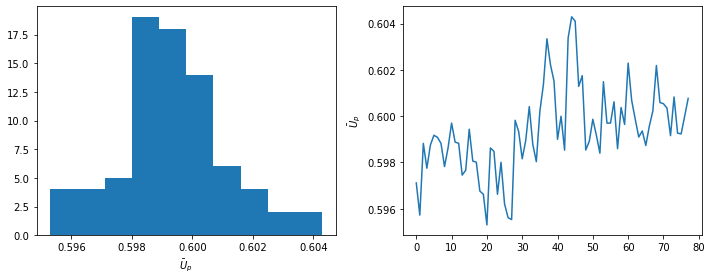

In [48]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.hist(plaq)
plt.xlabel('$\\bar{U}_p$')
plt.subplot(1,2,2)
plt.plot(plaq)
plt.ylabel('$\\bar{U}_p$')
plt.tight_layout()
plt.show()